### Importing libraries and data

In [1]:
import os
import pandas as pd
import numpy as np
import math
from math import sqrt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
%matplotlib inline

In [2]:
base_path = os.path.abspath('../../')
directory = os.path.join(base_path, 'Downloads/take_home_data_science_challenge')

In [3]:
sales = pd.read_excel(os.path.join(directory, 'case_study.xlsx'), index_col='ISO_Week', parse_dates=True)

In [4]:
sales.head(5)

,SKU,Sales,Season
ISO_Week,,,
2018-01,ProductA,0.0,WINTER
2018-02,ProductA,0.0,WINTER
2018-03,ProductA,0.0,WINTER
2018-04,ProductA,6988.0,WINTER
2018-04,ProductA,6988.0,WINTER


### Data Preprocessing and Feature Engineering

In [5]:
sales_pivot = pd.pivot_table(sales, values = 'Sales', index=['ISO_Week','Season'], columns = ['SKU'])

In [6]:
sales_pivot.head(10)

,SKU,ProductA,ProductB,ProductC
ISO_Week,Season,,,
2018-01,WINTER,0.0,NaN,NaN
2018-02,WINTER,0.0,NaN,NaN
2018-03,WINTER,0.0,NaN,NaN
2018-04,WINTER,6988.0,-23.0,NaN
2018-05,WINTER,6743.0,446.0,NaN
2018-06,WINTER,4112.0,361.0,NaN
2018-07,WINTER,5732.0,229.0,NaN
2018-08,WINTER,NaN,219.0,NaN
2018-09,SPRING,5559.0,495.0,NaN


In [7]:
sales_pivot.reset_index(inplace=True)

In [8]:
sales_pivot.head(5)

SKU,ISO_Week,Season,ProductA,ProductB,ProductC
0,2018-01,WINTER,0.0,NaN,NaN
1,2018-02,WINTER,0.0,NaN,NaN
2,2018-03,WINTER,0.0,NaN,NaN
3,2018-04,WINTER,6988.0,-23.0,NaN
4,2018-05,WINTER,6743.0,446.0,NaN


> Generating **Week_Number, Week_Sequence and Month** to provide additional information to the data

In [9]:
sales_pivot['ISO_Week'] = pd.to_datetime(sales_pivot.ISO_Week.add('-1'), format='%Y-%W-%w') 
sales_pivot['Week_Number'] = pd.to_numeric(sales_pivot['ISO_Week'].dt.day / 7)
sales_pivot['Week_Number'] = sales_pivot.Week_Number.apply(lambda x: math.ceil(x))
sales_pivot['Week_Sequence'] = pd.to_numeric(sales_pivot['ISO_Week'].dt.week)
sales_pivot['Month'] = pd.to_numeric(sales_pivot['ISO_Week'].dt.month)

In [10]:
sales_pivot.set_index('ISO_Week', inplace=True)

In [11]:
sales_pivot['ProductA_Promotion'] = sales_pivot.ProductA.apply(lambda x: x>10000)
sales_pivot['ProductC_Promotion'] = sales_pivot.ProductC.apply(lambda x: x>10000)

In [12]:
col = sales_pivot.columns.tolist()
col.insert(2, col.pop(col.index('ProductA_Promotion')))
sales_pivot = sales_pivot[col]

In [13]:
col = sales_pivot.columns.tolist()
col.insert(5, col.pop(col.index('ProductC_Promotion')))
sales_pivot = sales_pivot[col]

In [14]:
promotion_map = {True:1, False:0} 
season_map = {'AUTUMN':0, 'SPRING':1, 'SUMMER':2, 'WINTER':3}

In [15]:
sales_pivot['ProductA_Promotion'] = sales_pivot.ProductA_Promotion.map(promotion_map)
sales_pivot['ProductC_Promotion'] = sales_pivot.ProductC_Promotion.map(promotion_map)

### Exploratory Data Analysis

In [16]:
sales_pivot.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 52 entries, 2018-01-01 to 2018-12-24
Data columns (total 9 columns):
Season                52 non-null object
ProductA              48 non-null float64
ProductA_Promotion    52 non-null int64
ProductB              49 non-null float64
ProductC              42 non-null float64
ProductC_Promotion    52 non-null int64
Week_Number           52 non-null int64
Week_Sequence         52 non-null int64
Month                 52 non-null int64
dtypes: float64(3), int64(5), object(1)
memory usage: 4.1+ KB


In [17]:
sales_pivot.describe()

SKU,ProductA,ProductA_Promotion,ProductB,ProductC,ProductC_Promotion,Week_Number,Week_Sequence,Month
count,48.000000,52.000000,49.000000,42.000000,52.000000,52.000000,52.000000,52.000000
mean,7039.916667,0.326923,207.408163,9147.071429,0.461538,2.692308,26.500000,6.423077
std,3771.652794,0.473665,199.968218,8072.895417,0.503382,1.276307,15.154757,3.488615
min,0.000000,0.000000,-50.000000,-163.000000,0.000000,1.000000,1.000000,1.000000
25%,4519.500000,0.000000,0.000000,4414.750000,0.000000,2.000000,13.750000,3.750000
50%,6478.500000,0.000000,240.000000,10191.500000,0.000000,3.000000,26.500000,6.500000
75%,10425.000000,1.000000,385.000000,11592.000000,1.000000,4.000000,39.250000,9.250000
max,14853.000000,1.000000,495.000000,52524.000000,1.000000,5.000000,52.000000,12.000000


C:\Users\Saurav\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
C:\Users\Saurav\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


Text(0.5, 1.0, 'KDE Plot')

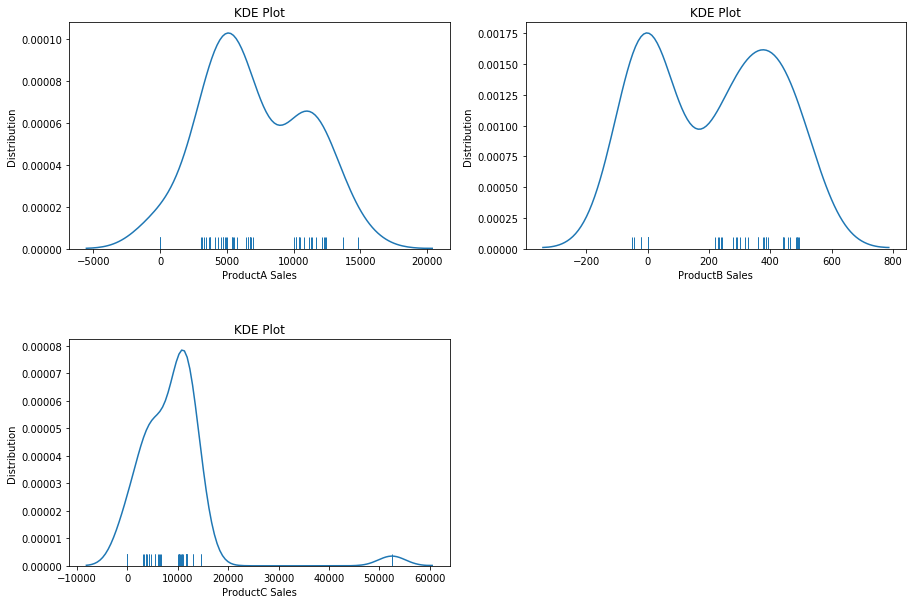

In [18]:
fig = plt.figure()
fig.subplots_adjust(hspace=0.4, wspace=0.2)
fig.set_figheight(10)
fig.set_figwidth(15)

ax1 = fig.add_subplot(2, 2, 1)
ax1 = sns.distplot(sales_pivot['ProductA'], rug=True, hist=False)
ax1.set_xlabel('ProductA Sales')  
ax1.set_ylabel('Distribution') 
ax1.set_title("KDE Plot") 

ax2 = fig.add_subplot(2, 2, 2)
ax2 = sns.distplot(sales_pivot['ProductB'], rug=True, hist=False)
ax2.set_xlabel('ProductB Sales')  
ax2.set_ylabel('Distribution') 
ax2.set_title("KDE Plot") 

ax3 = fig.add_subplot(2, 2, 3)
ax3 = sns.distplot(sales_pivot['ProductC'], rug=True, hist=False)
ax3.set_xlabel('ProductC Sales')  
ax3.set_ylabel('Distribution') 
ax3.set_title("KDE Plot") 


**Avg Sales for 3 SKUs over time**

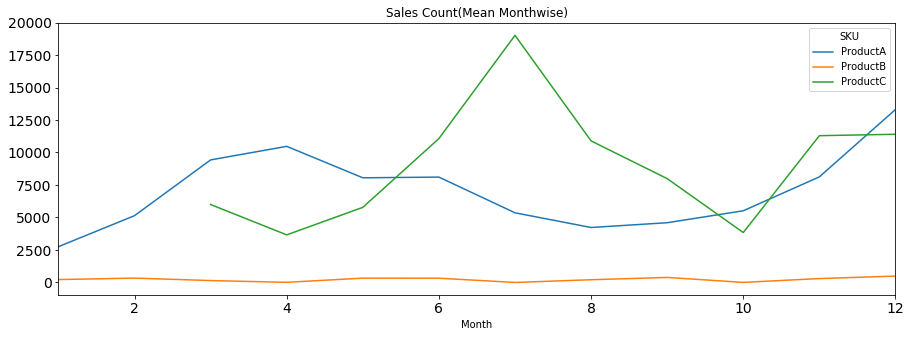

In [19]:
temp = sales_pivot.groupby(['Month'])['ProductA', 'ProductB', 'ProductC'].mean()
temp.plot(figsize=(15,5), title= 'Sales Count(Mean Monthwise)', fontsize=14)

**Sum Promotion Frequency over Time** 

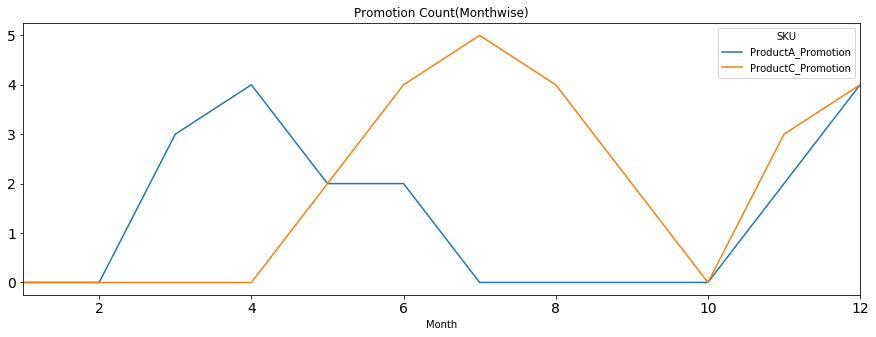

In [20]:
temp = sales_pivot.groupby(['Month'])['ProductA_Promotion', 'ProductC_Promotion'].sum()
temp.plot(figsize=(15,5), title= 'Promotion Count(Monthwise)', fontsize=14)

**SKUA Product Sales VS Season** 

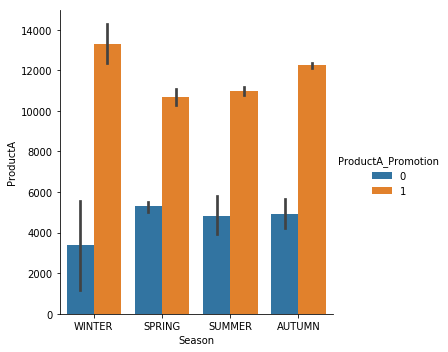

In [21]:
sns.catplot(x='Season', y='ProductA', hue='ProductA_Promotion', kind="bar", data=sales_pivot)

**SKUA Product Sales VS Week_Number VS Season** 

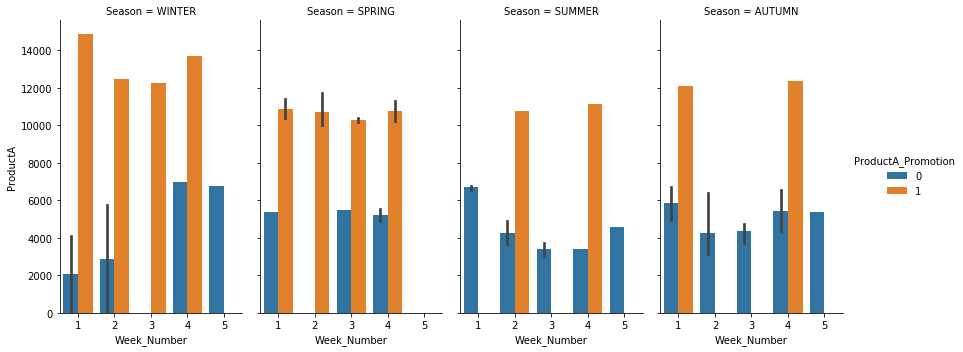

In [22]:
sns.catplot(x="Week_Number", y="ProductA", hue="ProductA_Promotion",
            col="Season", aspect=.6,
            kind="bar", data=sales_pivot);

**SKUB Product Sales VS Season** 

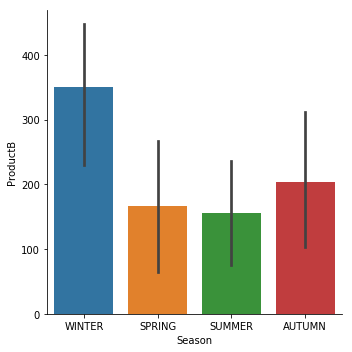

In [23]:
sns.catplot(x='Season', y='ProductB', kind="bar", data=sales_pivot)

**SKUC Product Sales VS Season** 

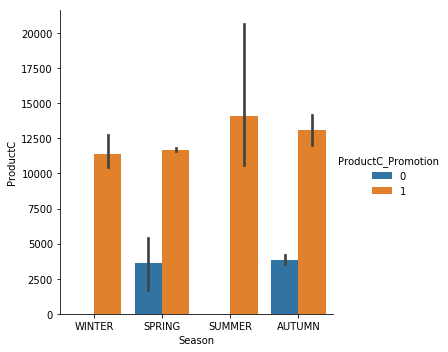

In [24]:
sns.catplot(x='Season', y='ProductC', hue='ProductC_Promotion', kind="bar", data=sales_pivot)

**SKUC Product Sales VS Week_Number VS Season** 

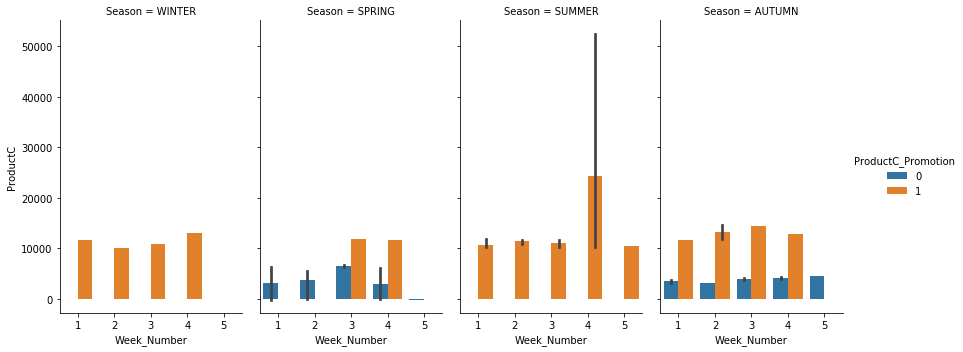

In [25]:
sns.catplot(x="Week_Number", y="ProductC", hue="ProductC_Promotion",
            col="Season", aspect=.6,
            kind="bar", data=sales_pivot);

In [26]:
sales_pivot['Season'] = sales_pivot.Season.map(season_map)

In [27]:
sales_pivot.head(15)

SKU,Season,ProductA,ProductA_Promotion,ProductB,ProductC,ProductC_Promotion,Week_Number,Week_Sequence,Month
ISO_Week,,,,,,,,,
2018-01-01,3,0.0,0,NaN,NaN,0,1,1,1
2018-01-08,3,0.0,0,NaN,NaN,0,2,2,1
2018-01-15,3,0.0,0,NaN,NaN,0,3,3,1
2018-01-22,3,6988.0,0,-23.0,NaN,0,4,4,1
2018-01-29,3,6743.0,0,446.0,NaN,0,5,5,1
2018-02-05,3,4112.0,0,361.0,NaN,0,1,6,2
2018-02-12,3,5732.0,0,229.0,NaN,0,2,7,2
2018-02-19,3,NaN,0,219.0,NaN,0,3,8,2
2018-02-26,1,5559.0,0,495.0,NaN,0,4,9,2


### Segregating data for 3 SKUs 
> The three SKUs vary heavily in terms of boundaries and promotional effect. If modelled under a single-umbrella, these important counters shall be marginalized.

In [28]:
prod_a = sales_pivot.loc[:, ['Season', 'ProductA', 'ProductA_Promotion', 'Week_Number', 'Week_Sequence','Month']]
prod_b = sales_pivot.loc[:, ['Season', 'ProductB', 'Week_Number', 'Week_Sequence', 'Month']]
prod_c = sales_pivot.loc['2018-03-18':, ['Season', 'ProductC', 'ProductC_Promotion', 'Week_Number', 'Week_Sequence', 'Month']]

### Handling NaN, Outliers

In [29]:
prod_a.dropna(inplace=True)
prod_b.dropna(inplace=True)
prod_c.dropna(inplace=True)

*Training Data Prior to 42nd Week*
*Prediction for 

In [30]:
train_a = prod_a.loc[prod_a['Week_Sequence'] < 42]
test_a = prod_a.loc[prod_a['Week_Sequence'] >= 42]

train_b = prod_b.loc[prod_b['Week_Sequence'] < 42]
test_b = prod_b.loc[prod_b['Week_Sequence'] >= 42]

train_c = prod_c.loc[prod_c['Week_Sequence'] < 42]
test_c = prod_c.loc[prod_c['Week_Sequence'] >= 42]

### Initial zero removal

In [31]:
train_a.drop(train_a[train_a.ProductA == 0].index, inplace=True)
train_b.drop(train_b[train_b.ProductB == 0].index, inplace=True)
train_c.drop(train_c[train_c.ProductC == 0].index, inplace=True)

train_a = train_a.drop(columns=['Week_Sequence'])
train_b = train_b.drop(columns=['Week_Sequence'])
train_c = train_c.drop(columns=['Week_Sequence'])

C:\Users\Saurav\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [32]:
train = [train_a, train_b, train_c]
test = [test_a, test_b, test_c]
product = ['ProductA', 'ProductB', 'ProductC']

### Outlier Handling

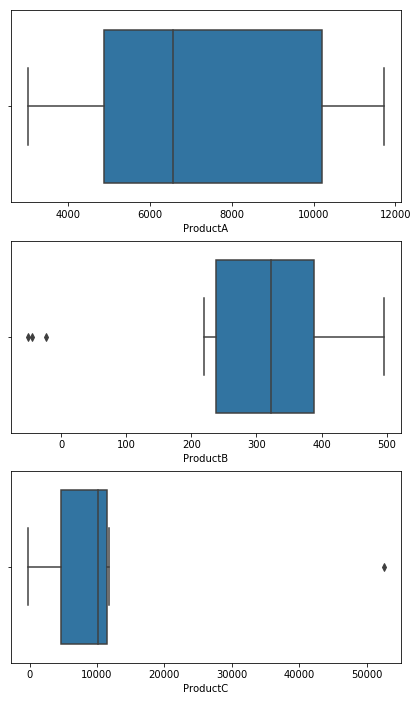

In [33]:
fig, axs = plt.subplots(3, 1, figsize=(7, 12))
sns.boxplot('ProductA', data=train_a, ax=axs[0])
sns.boxplot('ProductB', data=train_b, ax=axs[1])
sns.boxplot('ProductC', data=train_c, ax=axs[2])

In [34]:
for pos, i in enumerate(train):
    
    q75, q25 = np.percentile(i.loc[:, product[pos]], [75, 25])
    iqr = q75 - q25
    minimum = q25 - (iqr*1.5)
    maximum = q75 + (iqr*1.5)
    i.loc[i[product[pos]] < minimum, product[pos]] = np.nan
    i.loc[i[product[pos]] > maximum, product[pos]] = np.nan

In [35]:
for i in train:
    i.dropna(inplace=True)

In [36]:
train_a_y = train_a['ProductA']
train_a_X = train_a.drop(columns=['ProductA'])

train_b_y = train_b['ProductB']
train_b_X = train_b.drop(columns=['ProductB'])

train_c_y = train_c['ProductC']
train_c_X = train_c.drop(columns=['ProductC'])

train_y = [train_a_y, train_b_y, train_c_y]
train_X = [train_a_X, train_b_X, train_c_X]

In [37]:
for i in test:
    i.drop(columns=['Week_Sequence'], inplace=True)

In [38]:
test_a_y = test_a['ProductA']
test_a_X = test_a.drop(columns=['ProductA'])

test_b_y = test_b['ProductB']
test_b_X = test_b.drop(columns=['ProductB'])

test_c_y = test_c['ProductC']
test_c_X = test_c.drop(columns=['ProductC'])

test_y = [test_a_y, test_b_y, test_c_y]
test_X = [test_a_X, test_b_X, test_c_X]

In [39]:
from sklearn.ensemble import RandomForestRegressor

In [40]:
model_a = RandomForestRegressor(n_estimators=100)
model_b = RandomForestRegressor(n_estimators=100)
model_c = RandomForestRegressor(n_estimators=100)
model = [model_a, model_b, model_c]

In [41]:
for (i, j, k) in zip(model, train_X, train_y):
    
    i.fit(j, k)
    i.fit(j, k)
    i.fit(j, k)

In [42]:
pred_a = model_a.predict(test_a_X)
pred_b = model_b.predict(test_b_X)
pred_c = model_c.predict(test_c_X)

pred = [pred_a, pred_b, pred_c]

In [43]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [44]:
mape = mean_absolute_percentage_error(test_a_y.values, pred_a)
print("Mean Absolute Percentage error for ModelA: %.4f" % mape)

mape = mean_absolute_percentage_error(test_b_y, pred_b)
print("Mean Absolute Percentage error for ModelB: %.4f" % mape)

mape = mean_absolute_percentage_error(test_c_y, pred_c)
print("Mean Absolute Percentage error for ModelC: %.4f" % mape)

Mean Absolute Percentage error for ModelA: 21.1992
Mean Absolute Percentage error for ModelB: inf
Mean Absolute Percentage error for ModelC: 15.3772


- The inf MAPE for Model B is a result of presence of 0 in true values

In [45]:
print('R2 Score for ModelA:', model_a.score(test_a_X, test_a_y))
print('R2 Score for ModelB:', model_b.score(test_b_X, test_b_y))
print('R2 Score for ModelC:', model_c.score(test_c_X, test_c_y))

R2 Score for ModelA: 0.8136177220646345
R2 Score for ModelB: -0.4764381124980066
R2 Score for ModelC: 0.8428476552126927


> We can see that the Models for SKUA and SKUC yield descent R2 Score and MAPE, but the SKUB isn't.
The reason for this is the validation data present (which can't be tampered) for SKUB which is as follows for the starting 4 Weeks. <br>
- ISO_Week 
    1. 2018-10-15  **=====>**   -23.0
    2. 2018-10-22  **=====>**    0.0
    3. 2018-10-29  **=====>**    0.0
    4. 2018-11-05  **=====>**    0.0
- Any of the predicted values for these 4 weeks shall be contributing towards the error margin.

In [46]:
test_a_y = test_a_y.reset_index()
test_b_y = test_b_y.reset_index()
test_c_y = test_c_y.reset_index()

In [47]:
date_intervals = test_a_y['ISO_Week'].dt.strftime('%Y-%W')

In [48]:
data_a = {'ISO_Week': date_intervals, 'Forecast':pred_a}
data_b = {'ISO_Week': date_intervals, 'Forecast':pred_b}
data_c = {'ISO_Week': date_intervals, 'Forecast':pred_c}

In [49]:
op_a = pd.DataFrame(data=data_a)
op_b = pd.DataFrame(data=data_b)
op_c = pd.DataFrame(data=data_c)

In [50]:
op_a['SKU'] = 'ProductA'
op_b['SKU'] = 'ProductB'
op_c['SKU'] = 'ProductC'

In [51]:
op_a.index = op_a['SKU']
op_a.drop(columns='SKU', inplace=True)

op_b.index = op_b['SKU']
op_b.drop(columns='SKU', inplace=True)

op_c.index = op_c['SKU']
op_c.drop(columns='SKU', inplace=True)

In [52]:
final_op = pd.concat([op_a, op_b, op_c])

In [57]:
final_op['Forecast'] = final_op['Forecast'].apply(lambda x: math.ceil(x))

In [59]:
final_op.to_excel('Output.xlsx')

In [ ]:
# import plotly.plotly as ply
# import cufflinks as cf

In [ ]:
# from statsmodels.tsa.stattools import adfuller
# result = adfuller(prod_a_series['ProductA'].values, autolag='AIC')
# print('ADF Statistic: %f' % result[0])
# print('p-value: %f' % result[1])
# print('Critical Values:')
# for key, value in result[4].items():
# 	print('\t%s: %.3f' % (key, value))

In [ ]:
# rolmean = prod_a['ProductA'].rolling(window=4).mean()
# rolstd = prod_a['ProductA'].rolling(window=4).std()
# plt.figure(figsize=(15,5))
# #Plot rolling statistics:
# orig = plt.plot(prod_a['ProductA'], color='blue',label='Original')
# mean = plt.plot(rolmean, color='red', label='Rolling Mean')
# std = plt.plot(rolstd, color='black', label = 'Rolling Std')
# plt.legend(loc='best')
# plt.title('Rolling Mean & Standard Deviation')
# #plt.savefig('Rolling_Statistics.png', bbox_inches='tight')
# plt.show(block=False)

In [ ]:
# from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot, plot_mpl
# import plotly.graph_objs as go
# init_notebook_mode(connected=True)

In [ ]:
# iplot([{
#     'x': train_a_X.index,
#     'y': train_a_y,
# } ])

In [ ]:
# prod_a.index = pd.to_datetime(prod_a.index)

In [ ]:
# from plotly.plotly import plot_mpl
# from statsmodels.tsa.seasonal import seasonal_decompose
# result = seasonal_decompose(prod_a[['ProductA']].values, freq=4, model='additive')
# fig = result.plot()


In [ ]:
# from pmdarima import auto_arima
# stepwise_model = auto_arima(prod_a['ProductA'], start_p=0, start_q=0,
#                            max_p=3, max_q=3, m=12,
#                            start_P=0, seasonal=True,
#                            d=0, D=1,trace=True,
#                            error_action='ignore',  
#                            suppress_warnings=True, 
#                            stepwise=True)
# print(stepwise_model.aic())

In [ ]:
# train = prod_a.loc[:'2018-10-15']
# test = prod_a.loc['2018-10-15':]

In [ ]:
# stepwise_model.fit(train['ProductA'])

In [ ]:
# future_forecast = stepwise_model.predict(n_periods=11)
# pred_ts_a = future_forecast

In [ ]:
# mape = mean_absolute_percentage_error(test_a_y['ProductA'].values, pred_ts_a)
# print("Mean Absolute Percentage error for ModelA: %.4f" % mape)